In [65]:
from deep_bf.data_handler import DataLoader, rf2iq

dl = DataLoader("../../../rf_data")
# print(dl.df.head())

pw = dl.get_defined_pwdata("contrast_speckle_expe_dataset_rf", "RF")
# print(test.data.shape)
# print(test.fc, test.fs)

fs = pw.fs
fc = pw.fc

rf = pw.data

iq = rf2iq(rf, fs, fc)
print(iq.shape)

(75, 128, 2, 832)


In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleDAS(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.nz, self.nx = output_size

    def forward(self, iq, delays):
        b, n_ch, n_iq, n_samp = iq.shape

        x_folded = iq.reshape(b*n_ch, n_iq, 1, n_samp)
        delays_folded = delays.reshape(b*n_ch, self.nz, self.nx)

        #delays_folded = delays_folded.float()

        grid_x = 2.0 * (delays_folded / (n_samp -1)) - 1.0
        grid_y = torch.zeros_like(grid_x)
        grid = torch.stack((grid_x, grid_y), dim=-1)
        grid = grid.to(torch.float16)

        sampled = F.grid_sample(
            x_folded,
            grid,
            mode="bilinear",
            padding_mode="zeros",
            align_corners=True,
        )

        sampled = sampled.view(b, n_ch, n_iq, self.nz, self.nx)
        das = torch.sum(sampled, dim=1)

        return das

In [ ]:
class DifferentiableBMode(nn.Module):
    def __init__(self, dynamic_range=60, gain_db=0):
        super().__init__()
        self.dr = dynamic_range
        self.gain = gain_db
        self.min_signal = 1e-9 # Piso para evitar log(0)

    def forward(self, iq_sum):
        # iq_sum: [Batch, 2, Z, X]
        
        # 1. Envelope (Norma Euclidiana robusta)
        env = torch.norm(iq_sum, dim=1, keepdim=True)
        env = torch.clamp(env, min=self.min_signal)
        
        # 2. Log Compression
        env_db = 20 * torch.log10(env)
        
        # 3. Robust Normalization (Evita flickering)
        # Usamos el máximo de la imagen como referencia (0 dB)
        batch, ch, h, w = env_db.shape
        flat = env_db.view(batch, ch, -1)
        ref_val = flat.max(dim=-1, keepdim=True).values.view(batch, ch, 1, 1)
        
        # .detach() evita que la red aprenda a apagar el brillo global
        env_norm = env_db - ref_val.detach() + self.gain
        
        # 4. Range Mapping
        image = (env_norm + self.dr) / self.dr
        return torch.clamp(image, 0, 1)

In [111]:
import numpy as np

Nx = 512
Nz = 1024

z = np.linspace(pw.zlims[0], pw.zlims[-1], Nz)
x = np.linspace(-pw.aperture_width/2, pw.aperture_width/2, Nx)

x_ele_pos = np.linspace(-pw.aperture_width/2, pw.aperture_width/2, pw.n_channels)

Z, X = np.meshgrid(z, x, indexing="ij")
Y = X * 0
grid = np.stack((X, Y, Z), axis=-1, dtype=np.float32)

print(pw.probe_geometry.shape, X.shape, pw.probe_geometry[:, 0, None, None].shape)

d_rx = np.sqrt((X[None, ...] - pw.probe_geometry[:, 0, None, None])**2 + Z[None, ...]**2)
#d_rx = np.linalg.norm(grid[None, ...] - pw.probe_geometry[:, None, None, :], axis=-1)
t_rx = d_rx / pw.c0
print(t_tx.shape, t_rx.shape)

angle = pw.angles[pw.n_angles//2]
d_tx = X * np.sin(angle) + Z * np.cos(angle)
t_tx = d_tx / pw.c0 - pw.t0[pw.n_angles//2]

delays = t_tx[...] + t_rx
delays = delays * (fs / 4)
#delays = np.transpose(delays, (2, 0, 1))

print(t_tx.shape, t_rx.shape, delays.shape)
#



(128, 3) (1024, 512) (128, 1, 1)
(1024, 512) (128, 1024, 512)
(1024, 512) (128, 1024, 512) (128, 1024, 512)


In [112]:
delays_tensor = torch.from_numpy(delays).float().unsqueeze(0).cuda()

In [118]:
model = SimpleDAS(output_size=(Nz, Nx)).cuda()
post_proc = DifferentiableBMode(dynamic_range=50).cuda()

In [119]:
with torch.no_grad():
    iq_tensor = torch.from_numpy(iq[0,...]).unsqueeze(0).cuda()
    iq_das = model(iq_tensor, delays_tensor)
    b_mode = post_proc(iq_das)


In [117]:
iq_das[0,0,0,...]

tensor([-6.9160e-03, -9.4376e-03, -7.5607e-03, -2.9335e-03,  3.2902e-04,
         4.5662e-03,  5.5656e-03,  9.2926e-03,  7.6485e-03,  4.5967e-03,
         3.9062e-03, -6.2027e-03, -1.6510e-02, -3.1830e-02, -3.9825e-02,
        -5.1025e-02, -6.6467e-02, -8.7524e-02, -9.7961e-02, -1.0846e-01,
        -1.1517e-01, -1.2061e-01, -1.2439e-01, -1.1713e-01, -1.0327e-01,
        -9.0515e-02, -8.2825e-02, -6.7444e-02, -4.6448e-02, -2.4139e-02,
        -3.4580e-03,  9.0332e-03,  3.1982e-02,  5.0232e-02,  6.2866e-02,
         7.2693e-02,  8.9600e-02,  9.8328e-02,  1.0577e-01,  9.7351e-02,
         9.2712e-02,  8.6304e-02,  7.7881e-02,  6.6895e-02,  6.7871e-02,
         5.1544e-02,  3.0533e-02,  2.2171e-02,  1.2306e-02,  1.5612e-03,
        -1.5251e-02, -2.5558e-02, -3.5187e-02, -4.8798e-02, -5.3375e-02,
        -6.2073e-02, -6.6406e-02, -7.4646e-02, -8.0627e-02, -7.9529e-02,
        -8.8684e-02, -9.0881e-02, -9.4238e-02, -9.5154e-02, -9.7229e-02,
        -8.9966e-02, -8.7585e-02, -9.1675e-02, -9.9

4. Visualizando...


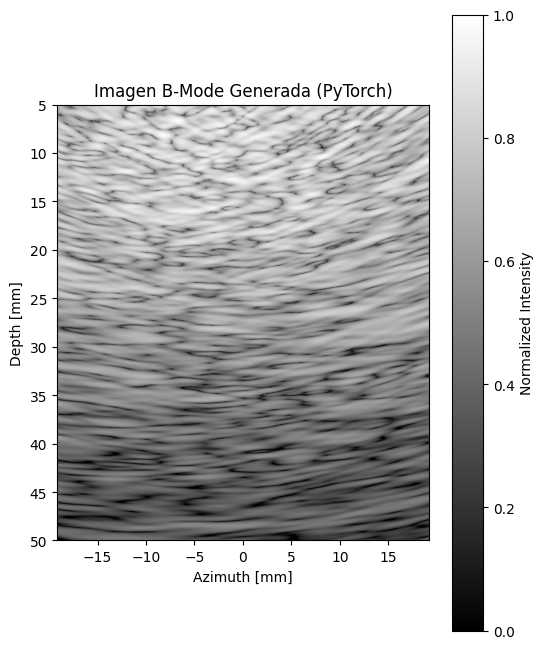

In [120]:
import matplotlib.pyplot as plt

zlims = grid[:, 0, 2] * 1e3
xlims = grid[0, :, 0] * 1e3


# --- E. VISUALIZACIÓN ---
print("4. Visualizando...")
img_np = b_mode.squeeze().cpu().numpy()

plt.figure(figsize=(6, 8))
plt.imshow(img_np, cmap='gray', extent=(xlims[0], xlims[-1], zlims[-1], zlims[0]))
plt.title("Imagen B-Mode Generada (PyTorch)")
plt.xlabel("Azimuth [mm]")
plt.ylabel("Depth [mm]")
plt.colorbar(label="Normalized Intensity")
plt.show()

4. Visualizando...


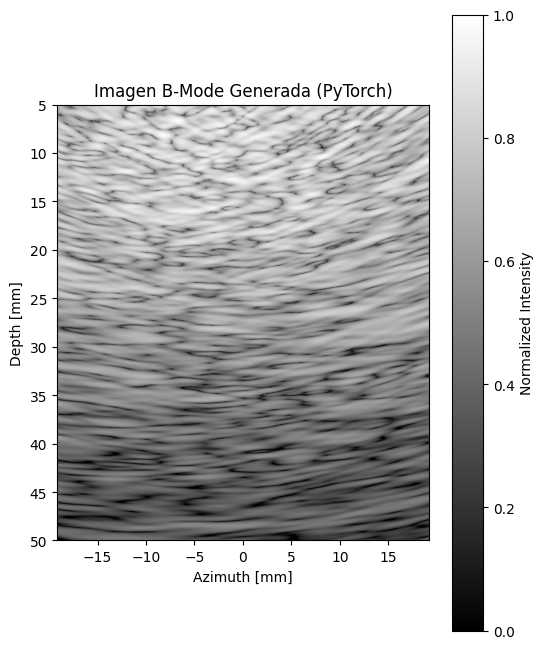

In [ ]:
import matplotlib.pyplot as plt

zlims = grid[:, 0, 2] * 1e3
xlims = grid[0, :, 0] * 1e3


# --- E. VISUALIZACIÓN ---
print("4. Visualizando...")
img_np = b_mode.squeeze().cpu().numpy()

plt.figure(figsize=(6, 8))
plt.imshow(img_np, cmap='gray', extent=(xlims[0], xlims[-1], zlims[-1], zlims[0]))
plt.title("Imagen B-Mode Generada (PyTorch)")
plt.xlabel("Azimuth [mm]")
plt.ylabel("Depth [mm]")
plt.colorbar(label="Normalized Intensity")
plt.show()